# Plant Seedlings Classification

## 1. Setup

In [91]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [92]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [93]:
PATH = os.path.join('data', 'sample') + '/'
#PATH = os.path.join('data') + '/'

In [94]:
ls {PATH}

test/  train/ valid/


If true, it means we will be able to utilize the GPU

In [95]:
torch.cuda.is_available()

False

If true, it means we will be able to utilize the GPU even better

In [96]:
torch.backends.cudnn.enabled

True

Since Mac keeps creating .DS_Store files I found a function for deleting it in the data directory.
Source: https://gist.github.com/mattsparks/19a0911999a623a3c302cc29c96b293a

In [97]:
def delete_ds_store():
    for root, dirs, files in os.walk(PATH):
        i = 0
        for file in files:
            if file.endswith('.DS_Store'):
                path = os.path.join(root, file)

                print("Deleting: %s" % (path))

                if os.remove(path):
                    print("Unable to delete!")
                else:
                    print("Deleted...")
                    i += 1

    print("Files Deleted: %d" % (i))


## 2. Exploratory analysis

### 2.1 Examining images

In [98]:
class_paths = glob(os.path.join(PATH, 'train', '*'))
class_names = [path.split('/')[-1] for path in class_paths]

Show two first images for each class to get the general idea how the data looks like.

/Users/michalstechly/Documents/Fast_AI/venv-fast-ai/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


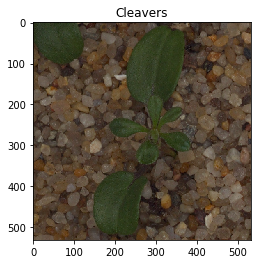

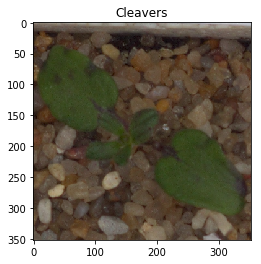

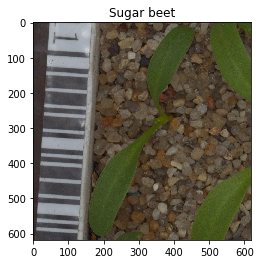

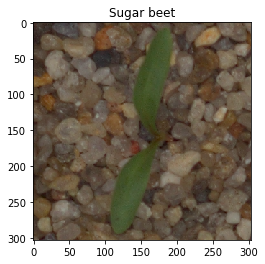

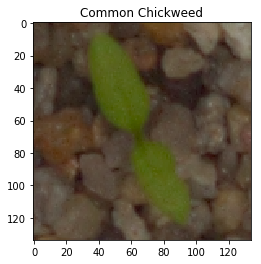

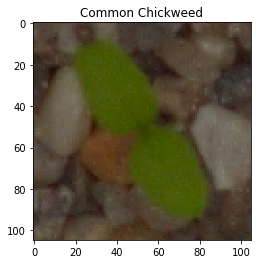

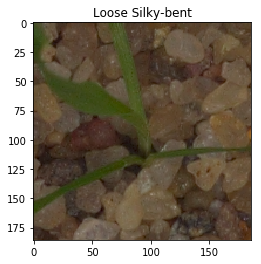

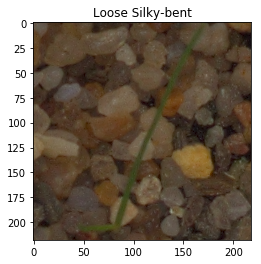

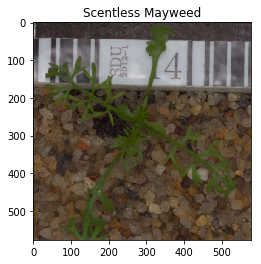

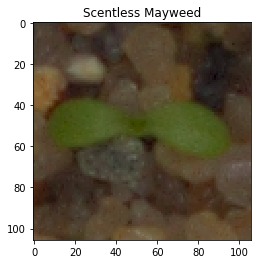

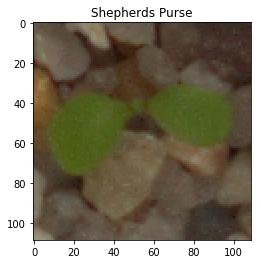

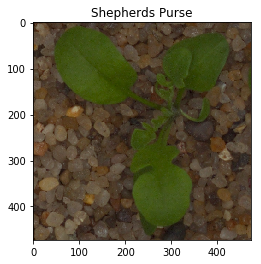

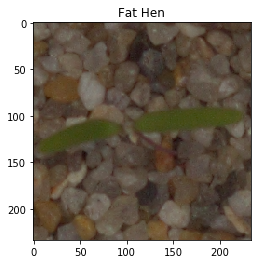

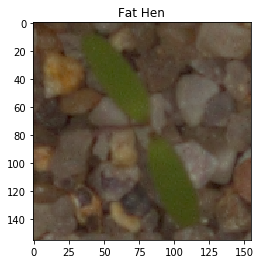

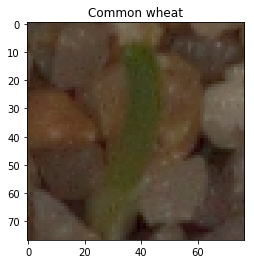

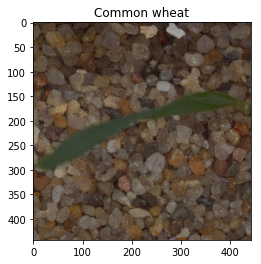

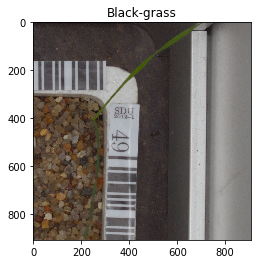

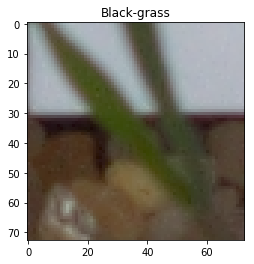

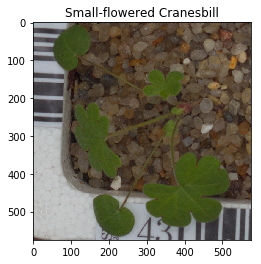

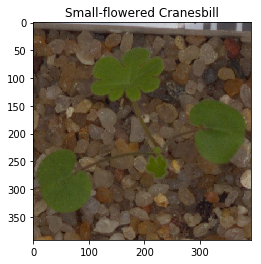

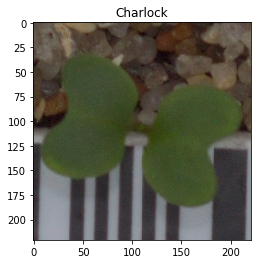

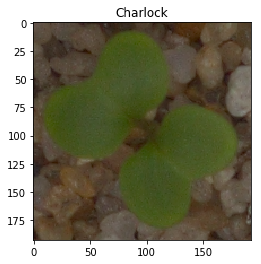

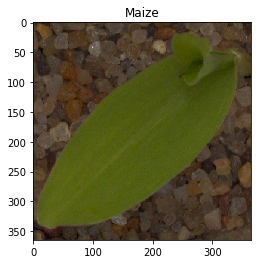

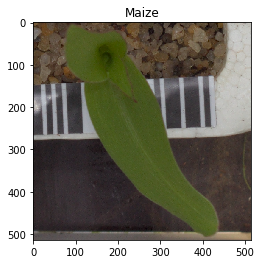

In [99]:
for class_name in class_names:
    files = glob(os.path.join(PATH, 'train', class_name)+'/*.png')
    for i in [0, 1]:
        img = plt.imread(files[i])
        plt.figure()
        plt.title(class_name)
        plt.imshow(img)

### 2.2 Image sizes

As we can see in the images above, they vary in size. 
Here I want to see how much.

In [100]:
raw_images = []
for class_name in class_names:
    files = glob(os.path.join(PATH, 'train', class_name)+'/*.png')
    for i in [0, 1]:
        raw_images.append(plt.imread(files[i]))

Each element of the raw_images list is a 3D array.
First two dimensions are height and width, and the third one is the RGB value of the image.

Checking if all the pictures are squared

In [101]:
not_square = []
for image in raw_images:
    not_square.append(image.shape[0] != image.shape[1])

In [104]:
number_of_not_square = sum(not_square)
print (number_of_not_square)
if number_of_not_square != 0:
    not_square_images = np.array(raw_images)[not_square]
    plt.title("Example of non square image.")
    plt.imshow(not_square_images[0])

0


Since part of the images are not squared, when analyzing the size of the pictures I will take into the account the higher value form width and height.

In [105]:
sizes_list = []
for image in raw_images:
    sizes_list.append(max(image.shape))

Min size: 73
Max size: 906


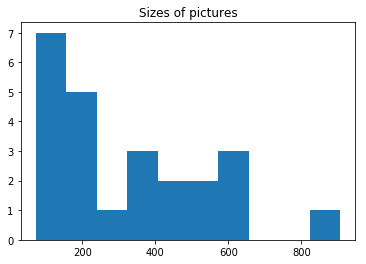

In [106]:
plt.title("Sizes of pictures")
plt.hist(sizes_list)
print("Min size:", min(sizes_list))
print("Max size:", max(sizes_list))

### 2.3 Conclusions

From the analysis so far, we can say that:
- Images vary in size (from 82 - 1900 pixels)
- Most, but not all of the images are square
- Photos seem to be taken from the top

## 3. Preparing the model

In [120]:
size = 64

In [123]:
delete_ds_store()

Files Deleted: 0


In [124]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, size))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 6)

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[0.      3.03111 2.55143 0.08333]                       
[1.      2.90395 2.44148 0.08333]                      
[2.      2.65323 2.36165 0.16667]                       
[3.      2.46659 2.30978 0.16667]                       
[4.      2.29635 2.27714 0.14583]                      
[5.      2.13462 2.2632  0.16667]                       



## 4. Examining the results

In [125]:
if 'sample' in PATH:
    visualization_size = 1
else:
    visualization_size = 4

In [126]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.amax(np.exp(log_preds),axis=1)

In [127]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], visualization_size, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)


In [128]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH + ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


Correctly classified


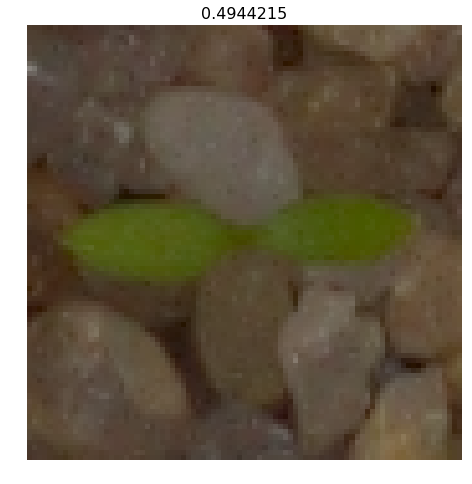

In [129]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


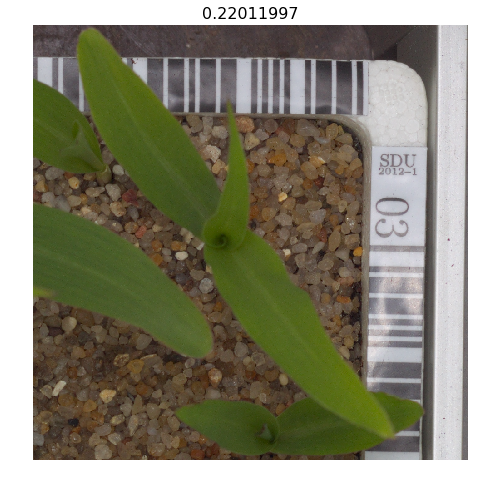

In [130]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [131]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


In [132]:
class_names = data.classes
for class_id in range(len(class_names)):
    print(class_names[class_id], class_id)
    plt.figure()
    plot_val_with_title(most_by_correct(class_id, True), "Most correct " + class_names[class_id])


Black-grass 0
Most correct Black-grass


ValueError: axes don't match array

In [ ]:
class_names = data.classes
for class_id in range(len(class_names)):
    print(class_names[class_id], class_id)
    plt.figure()
    plot_val_with_title(most_by_correct(class_id, False), "Most incorrect " + class_names[class_id])



## 5. Improving the model

### 5.1 Chosing the right learning rate

In [134]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [135]:
lrf=learn.lr_find()


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      3.07962 2.43727 0.14583]                       



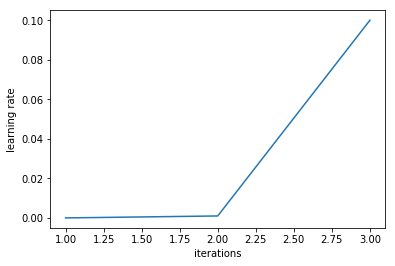

In [136]:
learn.sched.plot_lr()


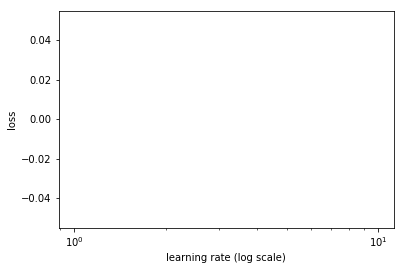

In [137]:
learn.sched.plot()


### 5.2 Data augmentation

In [141]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)

In [142]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [143]:
ims = np.stack([get_augs() for i in range(6)])


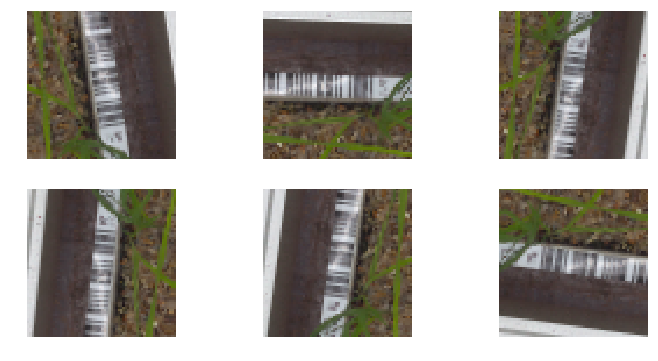

In [144]:
plots(ims, rows=2)

In [145]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [147]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      3.00584 2.49174 0.10417]                       
[1.      2.84142 2.35263 0.16667]                       
[2.      2.63638 2.23206 0.20833]                       



### 5.3 Adding cycles

In [148]:
learn.precompute=False

In [153]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      2.2142  2.11745 0.22917]                       
[1.      2.26249 2.09735 0.20833]                       
[2.      2.19139 2.09055 0.20833]                       
[3.      2.14861 2.05087 0.22917]                       
[4.      2.11424 2.01498 0.22917]                       
[5.      2.07763 2.00296 0.22917]                       
[6.      2.04145 1.99496 0.25   ]                       



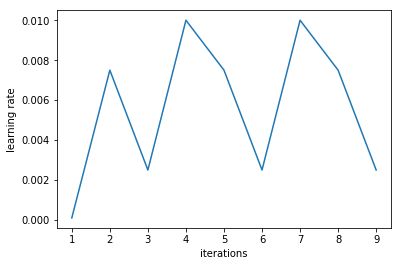

In [150]:
learn.sched.plot_lr()


In [151]:
learn.save('224_lastlayer')

In [152]:
learn.load('224_lastlayer')

### 5.4 Finetuning the network

In [155]:
learn.unfreeze()

In [156]:
learning_rate_base = 1e-2
lr=np.array([learning_rate_base/9,learning_rate_base/3,learning_rate_base])

In [157]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      2.49806 1.97982 0.29167]                       
[1.      2.41962 1.95214 0.29167]                       
[2.      2.36239 1.9984  0.29167]                       
[3.      2.27623 1.95812 0.29167]                       
[4.      2.18829 1.99963 0.27083]                       
[5.      2.09591 2.06576 0.25   ]                       
[6.      2.02481 2.04858 0.25   ]                       



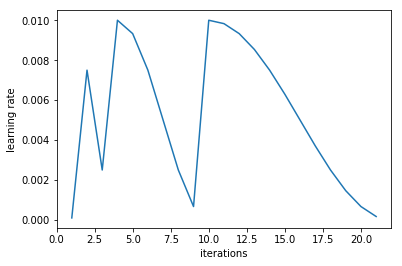

In [158]:
learn.sched.plot_lr()


In [159]:
learn.save('224_all')

In [160]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)


NameError: name 'accuracy_np' is not defined

## 6. Analyzing results again

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)


In [ ]:
plot_confusion_matrix(cm, data.classes)


In [ ]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")